In [19]:
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Input
from sklearn.base import BaseEstimator, RegressorMixin
# import statsmodels.api as sm

from common.utils import load_data, mape

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")



Load energy data in Pandas Dataframe

In [20]:
data_dir = 'C:\\Users\\Bam\\Desktop\\My-Project\\halfhourly_dataset'
energy = load_data(data_dir)[['load']]
energy.head()

,load
2012-10-12 00:30:00,0
2012-10-12 01:00:00,0
2012-10-12 01:30:00,0
2012-10-12 02:00:00,0
2012-10-12 02:30:00,0


Reduce dataframe to a month worth of data

In [21]:
start_date = '2013-08-01 00:00:00'
end_date = '2013-09-01 00:00:00'

energy = energy.loc[start_date:end_date]
energy.head()

,load
2013-08-01 00:00:00,0.154
2013-08-01 00:30:00,0.139
2013-08-01 01:00:00,0.104
2013-08-01 01:30:00,0.124
2013-08-01 02:00:00,0.104


The train / test split data ratio is 80% / 20%

In [22]:
train_start_date = '2013-08-01 00:00:00'
test_start_date = '2013-08-25 19:00:00'

Visualize energy data

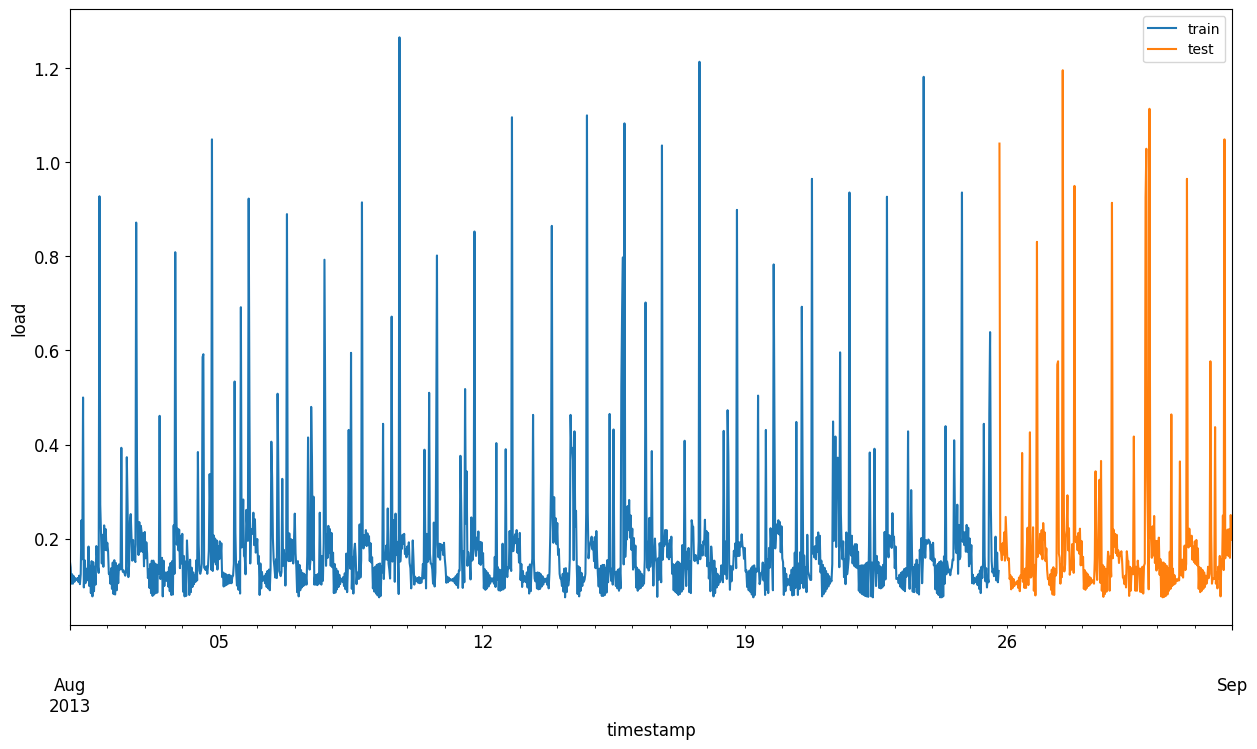

In [23]:
energy['load'] = pd.to_numeric(energy['load'])
energy[energy.index < test_start_date][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_date:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

Load weather data from different source into Pandas Dataframe

In [24]:
weather = pd.read_csv('C:\\Users\\Bam\\Desktop\\My-Project\\london_weather.csv')

weather['date'] = pd.to_datetime(weather['date'], format='%Y-%m-%d %H:%M')

weather.tail(2900)

,date,wind_speed,pressure,temperature,relative_humidity,precipitable_water,dew_point
0,2013-08-01 00:00:00,1.70,1012,15.80,100.00,3.10,15.80
1,2013-08-01 00:30:00,1.60,1012,15.60,100.00,3.00,15.60
2,2013-08-01 01:00:00,1.50,1012,15.40,100.00,3.00,15.40
3,2013-08-01 01:30:00,1.50,1012,15.30,100.00,3.00,15.30
4,2013-08-01 02:00:00,1.50,1011,15.10,100.00,3.00,15.10
...,...,...,...,...,...,...,...
1484,2013-08-31 22:00:00,2.40,1027,11.50,81.93,1.60,8.50
1485,2013-08-31 22:30:00,2.30,1027,11.30,83.02,1.50,8.50
1486,2013-08-31 23:00:00,2.20,1027,11.00,84.37,1.50,8.50
1487,2013-08-31 23:30:00,2.00,1027,10.60,86.64,1.50,8.50


Energy and Weather dataset integration and interpolation.

In [25]:
weather.set_index('date', inplace=True)

weather_energy = energy.merge(weather, how='left', left_index=True, right_index=True)

weather_energy.interpolate(method='time', inplace=True)

weather_energy.head(1191)

,load,wind_speed,pressure,temperature,relative_humidity,precipitable_water,dew_point
2013-08-01 00:00:00,0.15,1.70,1012,15.80,100.00,3.10,15.80
2013-08-01 00:30:00,0.14,1.60,1012,15.60,100.00,3.00,15.60
2013-08-01 01:00:00,0.10,1.50,1012,15.40,100.00,3.00,15.40
2013-08-01 01:30:00,0.12,1.50,1012,15.30,100.00,3.00,15.30
2013-08-01 02:00:00,0.10,1.50,1011,15.10,100.00,3.00,15.10
...,...,...,...,...,...,...,...
2013-08-25 17:00:00,0.11,2.90,1013,20.60,70.75,2.80,15.10
2013-08-25 17:30:00,0.17,2.20,1013,19.40,76.18,2.80,15.10
2013-08-25 18:00:00,0.11,1.50,1014,18.30,85.44,2.80,15.80
2013-08-25 18:30:00,0.13,1.50,1014,17.40,90.41,2.80,15.80


Feature engineering

In [26]:
energy['load'] = pd.to_numeric(energy['load'], errors='coerce')
peak_threshold = energy['load'].quantile(0.90)

bank_holidays = pd.read_csv('C:\\Users\\Bam\\Desktop\\My-Project\\uk_bank_holidays.csv')
bank_holidays['Bank holidays'] = pd.to_datetime(bank_holidays['Bank holidays']).dt.date
bank_holiday_dates = set(bank_holidays['Bank holidays'])

weather_energy['temp_humidity_interaction'] = weather_energy['temperature'] * weather_energy['relative_humidity']

weather_energy['hour'] = energy.index.hour
weather_energy['day_of_week'] = energy.index.dayofweek
weather_energy['month'] = energy.index.month
weather_energy['is_weekend'] = energy.index.dayofweek >= 5
weather_energy['is_peak_hour'] = np.where(energy['load'] >= peak_threshold, 1, 0)
weather_energy['is_bank_holiday'] = pd.Series(weather_energy.index.date).isin(bank_holiday_dates).values

# Lag features
weather_energy['previous_load'] = energy['load'].shift(1).fillna(0)
weather_energy['previous_is_peak_hour'] = weather_energy['is_peak_hour'].shift(1).fillna(0)
weather_energy['lag_3'] = energy['load'].shift(3).fillna(0)
weather_energy['rolling_mean_3'] = energy['load'].rolling(window=3).mean().fillna(0)
weather_energy['rolling_mean_2'] = energy['load'].rolling(window=2).mean().fillna(0)

weather_energy.head(1210)

,load,wind_speed,pressure,temperature,relative_humidity,precipitable_water,dew_point,temp_humidity_interaction,hour,day_of_week,month,is_weekend,is_peak_hour,is_bank_holiday,previous_load,previous_is_peak_hour,lag_3,rolling_mean_3,rolling_mean_2
2013-08-01 00:00:00,0.15,1.70,1012,15.80,100.00,3.10,15.80,"1,580.00",0,3,8,False,0,False,0.00,0.00,0.00,0.00,0.00
2013-08-01 00:30:00,0.14,1.60,1012,15.60,100.00,3.00,15.60,"1,560.00",0,3,8,False,0,False,0.15,0.00,0.00,0.00,0.15
2013-08-01 01:00:00,0.10,1.50,1012,15.40,100.00,3.00,15.40,"1,540.00",1,3,8,False,0,False,0.14,0.00,0.00,0.13,0.12
2013-08-01 01:30:00,0.12,1.50,1012,15.30,100.00,3.00,15.30,"1,530.00",1,3,8,False,0,False,0.10,0.00,0.15,0.12,0.11
2013-08-01 02:00:00,0.10,1.50,1011,15.10,100.00,3.00,15.10,"1,510.00",2,3,8,False,0,False,0.12,0.00,0.14,0.11,0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-08-26 02:30:00,0.09,2.70,1016,13.70,100.00,2.10,13.70,"1,370.00",2,0,8,False,0,True,0.12,0.00,0.16,0.11,0.11
2013-08-26 03:00:00,0.12,2.80,1016,13.70,100.00,2.10,13.70,"1,370.00",3,0,8,False,0,True,0.09,0.00,0.11,0.11,0.10
2013-08-26 03:30:00,0.10,2.70,1016,13.60,100.00,2.10,13.60,"1,360.00",3,0,8,False,0,True,0.12,0.00,0.12,0.10,0.11
2013-08-26 04:00:00,0.11,2.70,1016,13.50,100.00,2.20,13.50,"1,350.00",4,0,8,False,0,True,0.10,0.00,0.09,0.11,0.10


Splitting the data into training and testing sets

In [27]:
train = weather_energy[(weather_energy.index >= train_start_date) & (weather_energy.index <= test_start_date)]
test = weather_energy[(weather_energy.index >= test_start_date)]

X_train = train.drop(columns=['load'])
y_train = train['load']

X_test = test.drop(columns=['load'])
y_test = test['load']


#model = sm.OLS(y_train, X_train).fit()
# print(model.summary())

Building, Training and Using the Model

In [28]:
# Define the CNN model
def build_cnn(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))  # Use Input(shape) as the first layer
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Custom wrapper for Keras model compatible with scikit-learn
class KerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, build_fn, epochs=50, batch_size=10, verbose=0):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = None

    def fit(self, X, y):
        input_shape = (X.shape[1], 1)
        self.model = self.build_fn(input_shape)
        self.model.fit(X.reshape(-1, X.shape[1], 1), y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self

    def predict(self, X):
        return self.model.predict(X.reshape(-1, X.shape[1], 1))

# Define the pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  # Use MinMaxScaler
    ('selector', SelectKBest(score_func=f_regression)),
    ('cnn', KerasRegressorWrapper(build_cnn))
])

# Define the parameter grid
param_grid = {
    'selector__k': [1, 3, 6],
    'cnn__epochs': [50, 100],
    'cnn__batch_size': [10, 20]
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Predict energy consumption on the test set
y_pred = best_model.predict(X_test)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Evaluating the Model

In [29]:
print(f"Cross-validated MSE: {-np.mean(cv_scores)}")
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print('MAPE for testing data: ', mape * 100, '%')

Cross-validated MSE: 1.2252215591498329e-05
Mean Squared Error: 3.590279130014925e-05
MAPE for testing data:  2.8873219433632515 %


Plotting the Model's Prediction vs Actual (energy consumption)

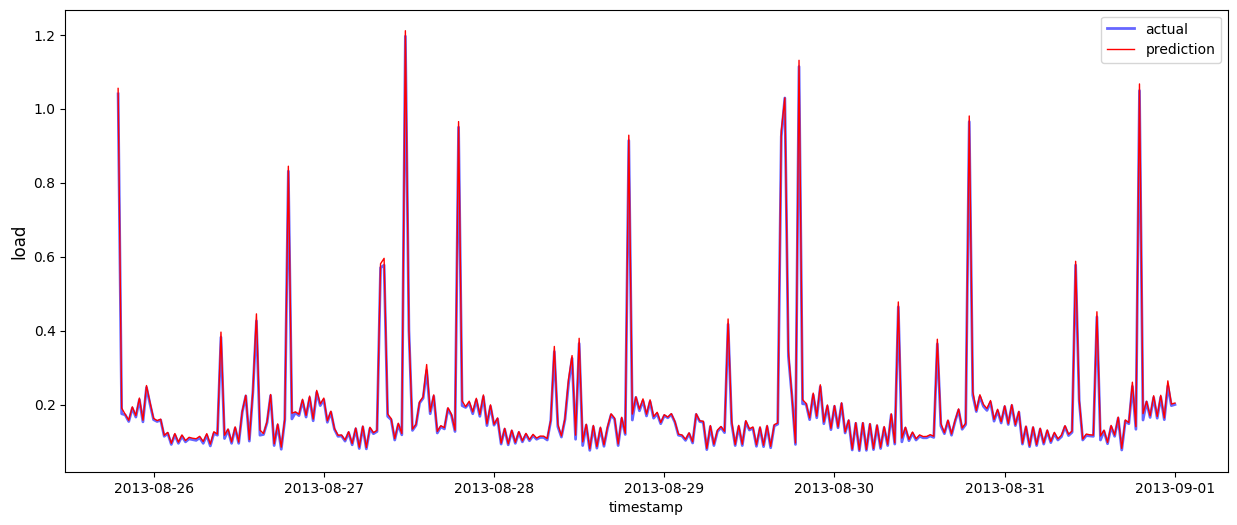

In [30]:
plt.figure(figsize=(15,6))
plt.plot(test.index, y_test, color = 'blue', linewidth=2.0, alpha = 0.6)
plt.plot(test.index, y_pred, color = 'red', linewidth=1.0)
plt.legend(['actual','prediction'])
plt.xlabel('timestamp')
plt.ylabel('load', fontsize=12)
plt.show()

Energy and Weather Dependency

1. Wind Speed

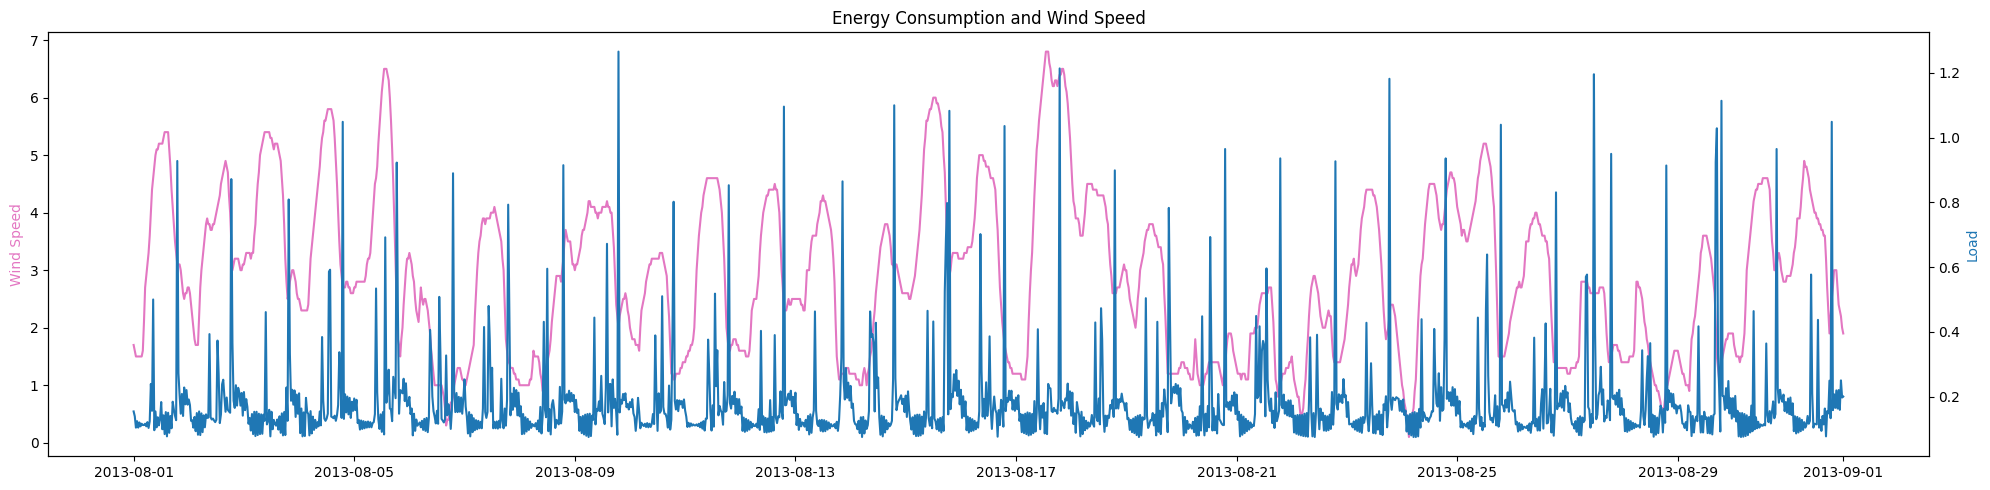

In [31]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.index, weather_energy.wind_speed, color = 'tab:pink')
ax1.set_ylabel('Wind Speed',color = 'tab:pink')
ax2 = ax1.twinx()
ax2.plot(weather_energy.index,weather_energy.load,color = 'tab:blue')
ax2.set_ylabel('Load',color = 'tab:blue')
plt.title('Energy Consumption and Wind Speed')
fig.tight_layout()
plt.show()

2. Pressure

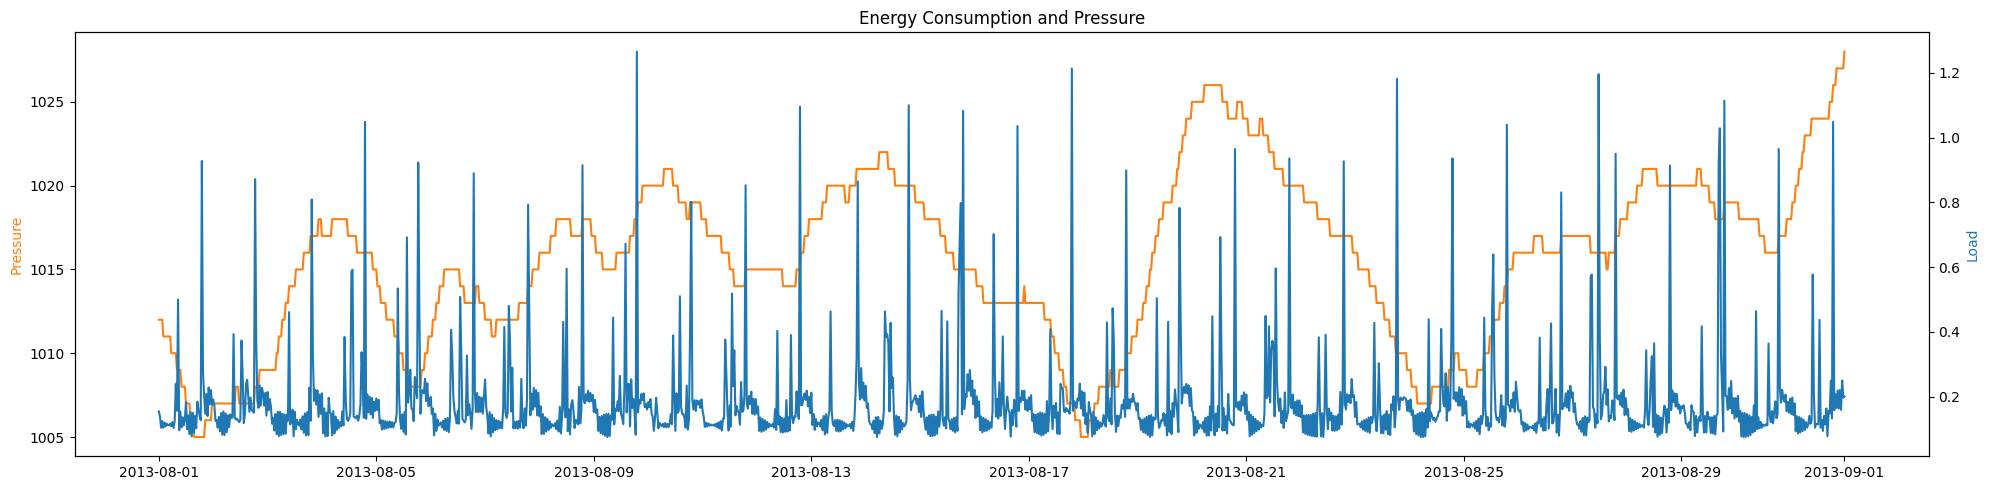

In [32]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.index, weather_energy.pressure, color = 'tab:orange')
ax1.set_ylabel('Pressure',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.index,weather_energy.load,color = 'tab:blue')
ax2.set_ylabel('Load',color = 'tab:blue')
plt.title('Energy Consumption and Pressure')
fig.tight_layout()
plt.show()

3. Temperature

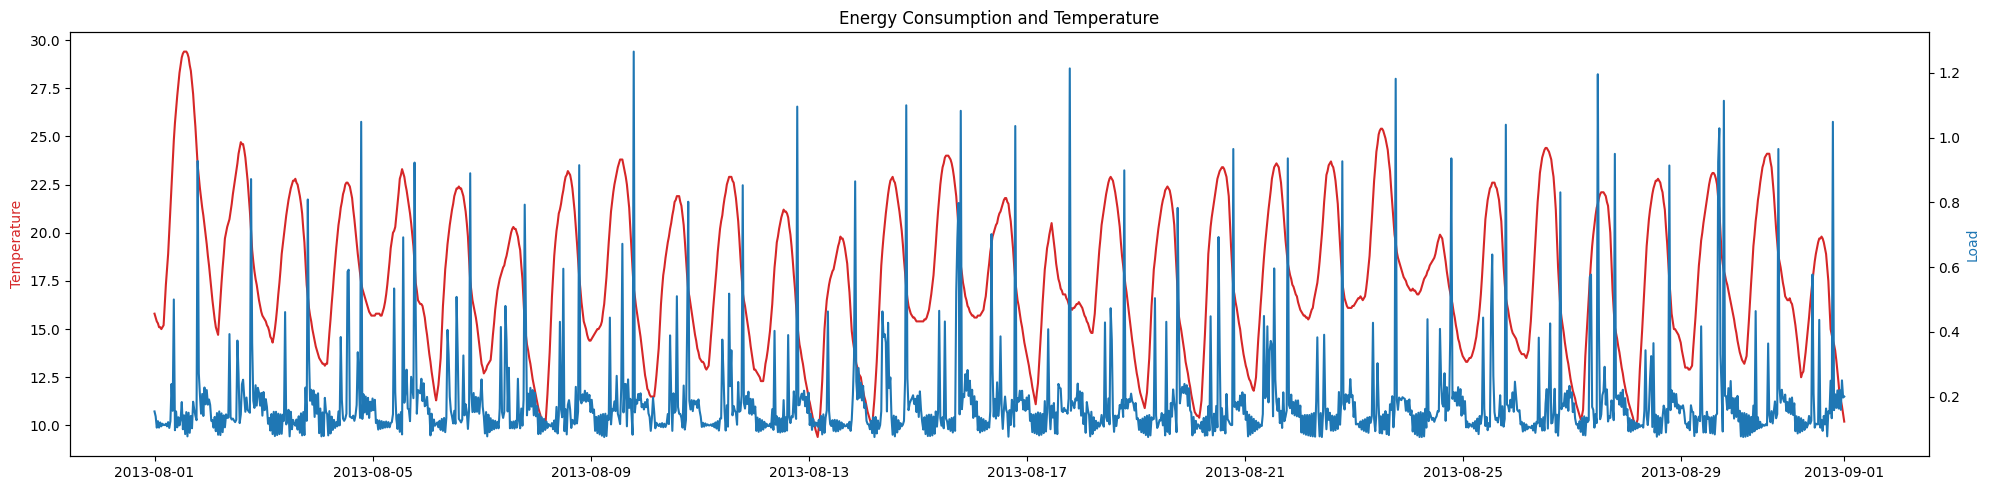

In [33]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.index, weather_energy.temperature, color = 'tab:red')
ax1.set_ylabel('Temperature',color = 'tab:red')
ax2 = ax1.twinx()
ax2.plot(weather_energy.index,weather_energy.load,color = 'tab:blue')
ax2.set_ylabel('Load',color = 'tab:blue')
plt.title('Energy Consumption and Temperature')
fig.tight_layout()
plt.show()

4. Relative humidity

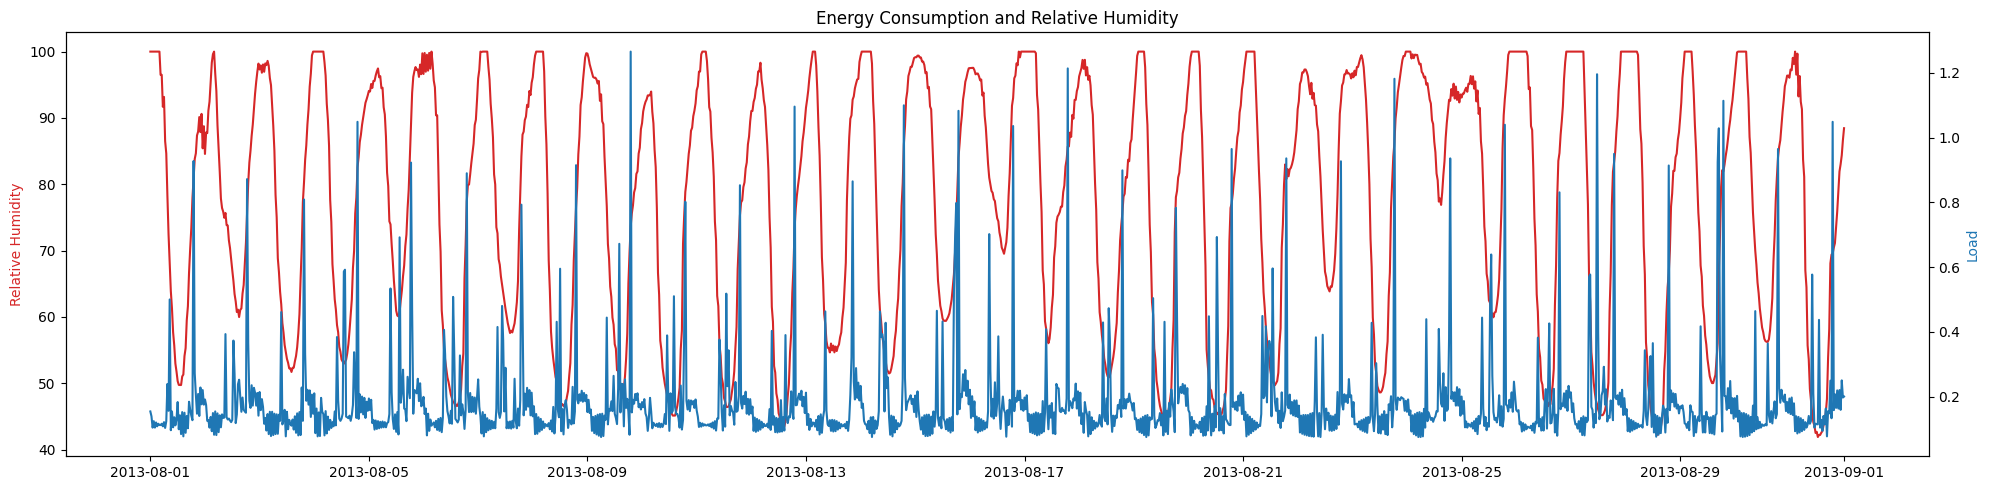

In [34]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.index, weather_energy.relative_humidity, color = 'tab:red')
ax1.set_ylabel('Relative Humidity',color = 'tab:red')
ax2 = ax1.twinx()
ax2.plot(weather_energy.index,weather_energy.load,color = 'tab:blue')
ax2.set_ylabel('Load',color = 'tab:blue')
plt.title('Energy Consumption and Relative Humidity')
fig.tight_layout()
plt.show()

5. Precitable Water

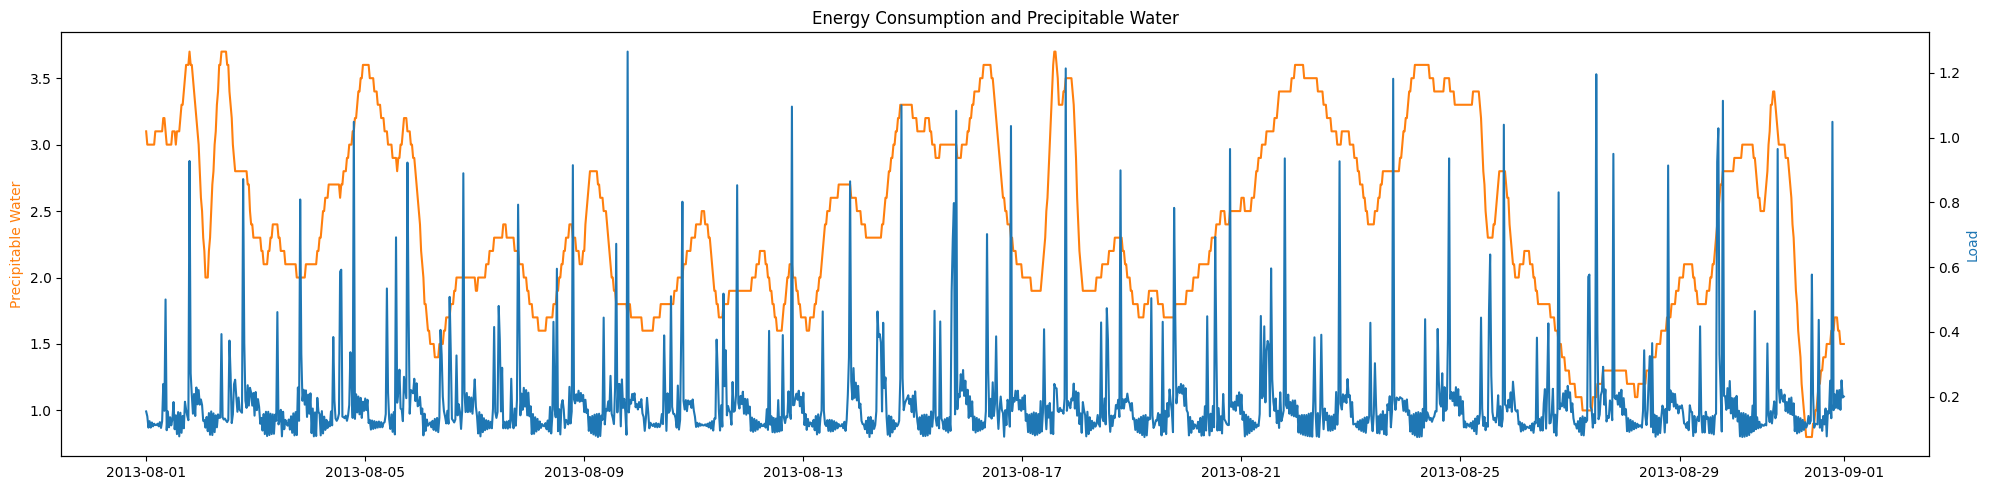

In [35]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.index, weather_energy.precipitable_water, color = 'tab:orange')
ax1.set_ylabel('Precipitable Water',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.index,weather_energy.load,color = 'tab:blue')
ax2.set_ylabel('Load',color = 'tab:blue')
plt.title('Energy Consumption and Precipitable Water')
fig.tight_layout()
plt.show()

6. Dew Point

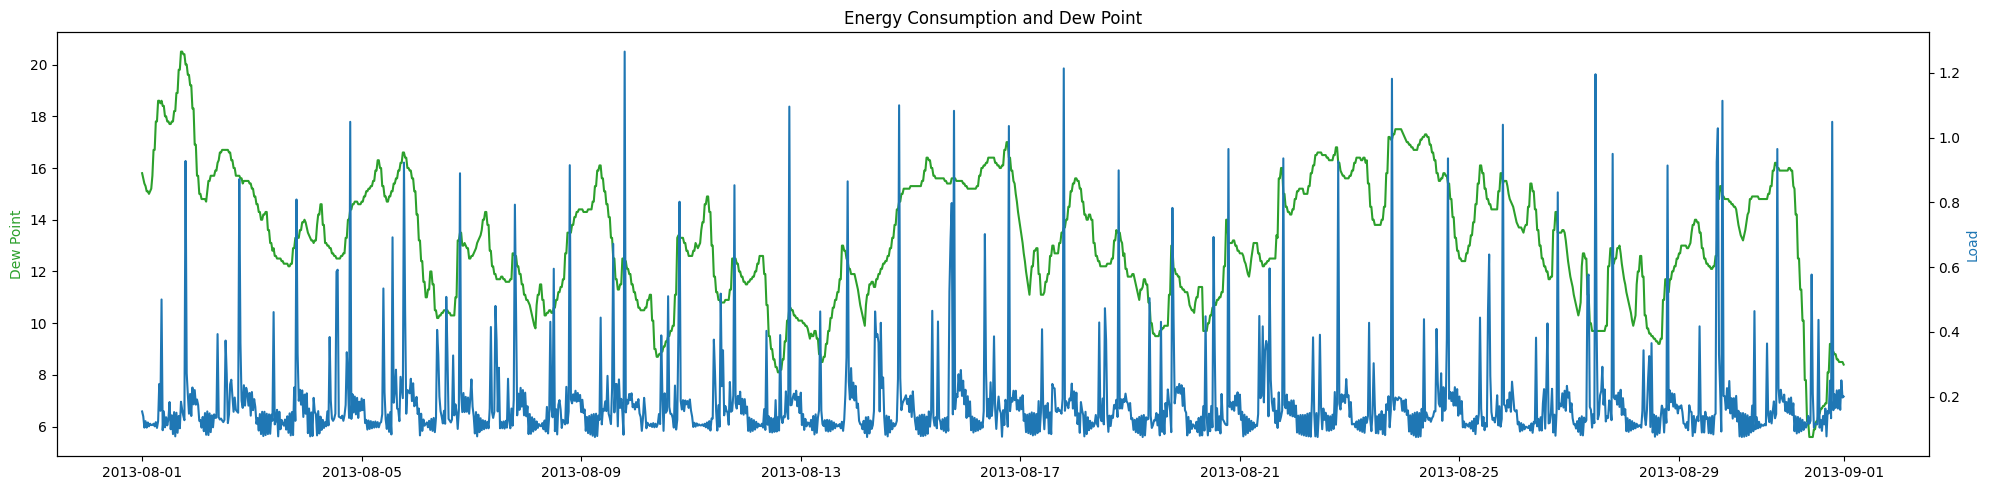

In [36]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.index, weather_energy.dew_point, color = 'tab:green')
ax1.set_ylabel('Dew Point',color = 'tab:green')
ax2 = ax1.twinx()
ax2.plot(weather_energy.index,weather_energy.load,color = 'tab:blue')
ax2.set_ylabel('Load',color = 'tab:blue')
plt.title('Energy Consumption and Dew Point')
fig.tight_layout()
plt.show()